In [1]:
import scipy.io
import pickle
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [2]:
components = scipy.io.loadmat('auditory_brain_dnn/data/neural/NH2015comp/components.mat')
ytrue = components['R']
stim_names = components['stim_names']

x = []
for s in stim_names[0]:
    s_data = []
    filename = f'auditory_brain_dnn/model_actv/mel256-ec-base/{s[0]}_activations.pkl'
    with open(filename,'rb') as f:
        act_data = pickle.load(f)
        for i in range(10):
            s_data.append(act_data[i])
    x.append(s_data)
x = np.array(x)

In [ ]:
FAST_LOO=True

n_train=83
N_CV=10
all_test_r2 = []
for layer in range(10):
    test_r2 = []
    models = []
    for i in tqdm(range(N_CV)):
        idxs = np.random.permutation(np.arange(len(ytrue)))
        train_idxs = idxs[:n_train]
        test_idxs = idxs[n_train:]
        x_train = x[train_idxs, layer]
        x_test = x[test_idxs, layer]
        y_train = ytrue[train_idxs]
        y_test = ytrue[test_idxs]
        
        possible_alphas = [10 ** x for x in range(-50, 50)]
        if FAST_LOO:
            model = RidgeCV(possible_alphas)
        else:
            model = RidgeCV(possible_alphas, cv=LeaveOneOut(), scoring='neg_mean_squared_error')
        scaler_x = StandardScaler(with_std=False)
        scaler_y = StandardScaler(with_std=False)
        x_train = scaler_x.fit_transform(x_train)
        x_test = scaler_x.transform(x_test)
        y_train = scaler_y.fit_transform(y_train)
        model.fit(x_train, y_train)
        yhat_test = model.predict(x_test)
        yhat_test = yhat_test + scaler_y.mean_
        test_r2.append(r2_score(y_test, yhat_test, multioutput='raw_values'))
        models.append(model)
    test_r2 = np.array(test_r2)
    all_test_r2.append(test_r2)
all_test_r2 = np.array(all_test_r2)
median_test_r2 = np.median(all_test_r2,axis=1)

  0%|                                                                                                          | 0/10 [00:00<?, ?it/s]/home/lpepino/miniconda3/envs/braindnn/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=2.98387e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/lpepino/miniconda3/envs/braindnn/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/lpepino/miniconda3/envs/braindnn/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/lpepino/miniconda3/envs/braindnn/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solutio

In [6]:
median_test_r2

array([[0.57756273, 0.48422831, 0.34584682, 0.4237192 , 0.14630466,
        0.28409856],
       [0.77915002, 0.70823019, 0.34318143, 0.68654019, 0.5231534 ,
        0.53493301],
       [0.82919631, 0.76923078, 0.49771323, 0.80090691, 0.78152205,
        0.65946306],
       [0.84727789, 0.77451251, 0.47960438, 0.86378556, 0.86516655,
        0.76832741],
       [0.84581024, 0.77643633, 0.59630933, 0.84538477, 0.90797984,
        0.74823004],
       [0.83100828, 0.7534486 , 0.58266708, 0.84963428, 0.923912  ,
        0.79280073],
       [0.84532204, 0.75743301, 0.57552978, 0.84475887, 0.91787794,
        0.75549884],
       [0.8249115 , 0.72507899, 0.53844336, 0.85349977, 0.91040992,
        0.77896815],
       [0.80541721, 0.69400602, 0.561837  , 0.82755393, 0.90560603,
        0.75534356],
       [0.83830721, 0.77608634, 0.5397339 , 0.83539859, 0.91416652,
        0.76417732]])

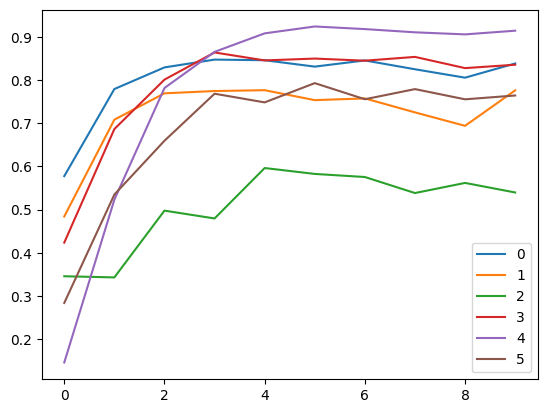

In [7]:
for c in range(6):
    plt.plot(median_test_r2[:,c], label=c)
plt.legend()